# Naive Bayes
[The sklearn documentation](https://scikit-learn.org/stable/modules/naive_bayes.html) contains a good explanation for Naive Bayes. It (naively) assumes conditional independence between all of the classes and tries to find the maximum likely y based on $P(y)\Pi_{i=1}^N P(x_i|y)$. We don't have specific classes to classify to, but given multiple headlines, we need to find the winner and thus the most likely one (accoording to th people that picked the winners) to be the most popular one. The different classes (y) are then the different headlines, so we can just keep P(y) out of the equation.

Since all the manually assigned labels are bernouilli distributed, we can use the [Bernoulli Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#bernoulli-naive-bayes). However, we still have the problem that we want the headline with the maximum probability to be the winner and not assign for each of them whether it's a winner or not (the classifications per test are dependent on each other).

## Train Data

In [33]:
import numpy as np

from util import get_wpm_train_test
train_x, train_y, test_x, test_y = get_wpm_train_test(full_y_test=True)
train_x.head()

,Test,Headline ID,Headline,Actief,Lang,Vragen,Interpunctie,Tweeledigheid,Emotie,Voorwaartse Verwijzing,Signaalwoorden,Lidwoorden,Adjectieven,Eigennamen,Betrekking,Voor+Achternaam,Cijfers,Quotes
0,1,A,Barack en Michelle Obama laten dansmoves zien ...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,B,Barack en Michelle Obama gaan helemaal los tij...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,A,Marc Coucke maakt opvallende keuze bij start v...,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,2,B,"Marc Coucke: ""Spelers van 10 miljoen? Neen, li...",1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
4,3,A,Maandag drukste dag van het jaar op Brussels A...,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1


In [34]:
test_x.head()

,Test,Headline ID,Headline,Actief,Lang,Vragen,Interpunctie,Tweeledigheid,Emotie,Voorwaartse Verwijzing,Signaalwoorden,Lidwoorden,Adjectieven,Eigennamen,Betrekking,Voor+Achternaam,Cijfers,Quotes
11,6,A,Cafébazin krijgt GAS-boete van 350 euro omdat ...,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
12,6,B,Cafébazin krijgt GAS-boete van 350 euro omdat ...,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0
61,24,A,"Zaakvoerder betrapt winkeldief, en niet alleen...",1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
62,24,B,Betrapte dievegge in winterjas staat plots op ...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
65,26,A,"Knuffel is op zoek naar verloren kindje: ""Mijn...",1,1,0,0,1,1,0,0,0,0,0,0,0,0,1


In [35]:
from util import get_manually_labeled_features
train_x_features = get_manually_labeled_features(train_x)
train_x_features.head()

,Actief,Lang,Vragen,Interpunctie,Tweeledigheid,Emotie,Voorwaartse Verwijzing,Signaalwoorden,Lidwoorden,Adjectieven,Eigennamen,Betrekking,Voor+Achternaam,Cijfers,Quotes
0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
4,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1


In [36]:
train_y_winner = train_y['Winner']
train_y_winner.head()

0    False
1     True
2     True
3    False
4     True
Name: Winner, dtype: bool

## Training

### Predict labels

In [37]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()

model.fit(train_x_features, train_y_winner)

BernoulliNB()

Based on this model, we can try to predict the winner for each headline independently (so it's for example possible (even highly probable) that one test has multiple winners or none winner).

In [38]:
test_x_features = get_manually_labeled_features(test_x)
predictions = model.predict(test_x_features)
predictions[:5]

array([False, False,  True, False, False])

For example for the first headline (corresponding with row 0 and 1) we can see that there is no winner.

f-score: 0.4246575342465754
Confusion matrix: (TP: 223, FP: 48, FN: 120, TN: 62)
Accuracy=62.91% (285/453)


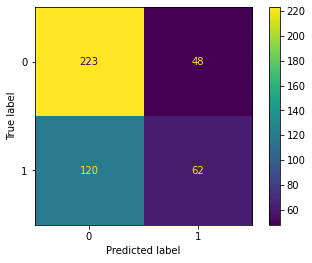

In [39]:
from util import print_evaluation
test_y_winner = test_y['Winner']
print_evaluation(test_y_winner, predictions)

The results are actually less bad than I expected (but still not good). Because all tests have at least one Winner=False and exactly one Winner=True, there are a lot more negative values than positive values (and because of this data imbalance, the chance of predicting winner as negative is of course also higher, which explains the higher than expected results).

In [40]:
# Create a new dataframe, being test_x with an extra column for the predictions
from util import get_label_columns, drop_labels
test_x_predictions = drop_labels(test_x) # drop some columns for readability
test_x_predictions['Winner'] = predictions
test_x_predictions.head()

,Test,Headline ID,Headline,Winner
11,6,A,Cafébazin krijgt GAS-boete van 350 euro omdat ...,False
12,6,B,Cafébazin krijgt GAS-boete van 350 euro omdat ...,False
61,24,A,"Zaakvoerder betrapt winkeldief, en niet alleen...",True
62,24,B,Betrapte dievegge in winterjas staat plots op ...,False
65,26,A,"Knuffel is op zoek naar verloren kindje: ""Mijn...",False


In [41]:
# See how many rows with same id in "Test" have exactly one Winner=True row
exactly_one_winner_predicted_tests = test_x_predictions.groupby('Test').filter(lambda x: x['Winner'].sum() == 1)
# Only keep winner=true rows
exactly_one_winner_predicted_tests = exactly_one_winner_predicted_tests[exactly_one_winner_predicted_tests['Winner'] == True]
print(f"{len(exactly_one_winner_predicted_tests)} tests have exactly one winner predicted (out of {len(test_x.Test.unique())} tests)")

55 tests have exactly one winner predicted (out of 182 tests)


Let's see how many of those are correct:

In [42]:
winners_only = exactly_one_winner_predicted_tests[exactly_one_winner_predicted_tests['Winner'] == True]
test_y_winner_only = test_y[test_y['Winner'] == True]
# Get how many (Test, Headline ID) pairs of winners only are in the test_y_winner_only dataframe
winners_only_in_test_y_winner_only = winners_only.merge(test_y_winner_only, on=['Test', 'Headline ID'], how='inner')
print(f"{len(winners_only_in_test_y_winner_only)} winners are predicted correctly")

38 winners are predicted correctly


Given the 47 tests with exactly one winner, this number is reasonable (70% accuracy). Maybe this is still better because there are some features that characterize a bad news headline. When looking at all tests, this number is of course terribly row (18% accuracy).

### Predict scores
Up to now, we have assigned a winner label true or false. However, we want only one winner per test, so a possible way is to assign a score to each headline and assign the winner label to the headline with the highest score. The [BernouilliNB documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) contains a method `predict_proba` that returns the probability of each class for each row (and thus how likely winner=True accoording to the model, of which we can take the max). Let's try.

In [43]:
predicted_probs = model.predict_proba(test_x_features)
predicted_probs[:5]

array([[0.84045974, 0.15954026],
       [0.81509241, 0.18490759],
       [0.36713847, 0.63286153],
       [0.64815556, 0.35184444],
       [0.54601412, 0.45398588]])

Add those probabilities to a copy of the test_x_predictions dataframe.

In [44]:
import pandas as pd
test_x_predictions = drop_labels(test_x) # drop some columns for readability

assert len(test_x_predictions) == len(predicted_probs)
print(f"{len(test_x_predictions)} rows in test_x_predictions")

class_names = list(range(len(model.classes_)))

test_x_predictions.reset_index(drop=True, inplace=True) # This is important to map the first row of predicted probs to the first row of test_x_predictions, otherwise, it will map those rows to the original dataframe and thus not provide a number for each of the row (resulting in a lot of NaN's) (took way too long for me to find this problem)
test_x_predictions[class_names] = pd.DataFrame(predicted_probs)
test_x_predictions.head()

453 rows in test_x_predictions


,Test,Headline ID,Headline,0,1
0,6,A,Cafébazin krijgt GAS-boete van 350 euro omdat ...,0.840460,0.159540
1,6,B,Cafébazin krijgt GAS-boete van 350 euro omdat ...,0.815092,0.184908
2,24,A,"Zaakvoerder betrapt winkeldief, en niet alleen...",0.367138,0.632862
3,24,B,Betrapte dievegge in winterjas staat plots op ...,0.648156,0.351844
4,26,A,"Knuffel is op zoek naar verloren kindje: ""Mijn...",0.546014,0.453986


Take the candidate headline with the highest winner probability (column 1) for each test

In [45]:
predicted_winners = test_x_predictions.groupby('Test').apply(lambda x: x.sort_values(by=1, ascending=False).head(1))
predicted_winners.head()

,,Test,Headline ID,Headline,0,1
Test,,,,,,
6,1,6,B,Cafébazin krijgt GAS-boete van 350 euro omdat ...,0.815092,0.184908
24,2,24,A,"Zaakvoerder betrapt winkeldief, en niet alleen...",0.367138,0.632862
26,6,26,C,Duizenden mensen zoeken mee naar eigenaar van ...,0.172852,0.827148
31,7,31,A,Deze vijfjarige is 'het mooiste meisje op Inst...,0.349084,0.650916
32,10,32,B,Bekende actrice (op leeftijd) nieuwe ster van ...,0.268926,0.731074


Filter test_y to only get winner=True (note: normally this is the case, but now not since we supplied the full_y_test=True label in our get_wpm_train_test function)

In [46]:
test_y_winner = test_y[test_y['Winner'] == True]
test_y_winner.head()

,Test,Headline ID,Winner
11,6,A,True
61,24,A,True
67,26,C,True
78,31,B,True
80,32,B,True


In [47]:
predicted_winners

,,Test,Headline ID,Headline,0,1
Test,,,,,,
6,1,6,B,Cafébazin krijgt GAS-boete van 350 euro omdat ...,0.815092,0.184908
24,2,24,A,"Zaakvoerder betrapt winkeldief, en niet alleen...",0.367138,0.632862
26,6,26,C,Duizenden mensen zoeken mee naar eigenaar van ...,0.172852,0.827148
31,7,31,A,Deze vijfjarige is 'het mooiste meisje op Inst...,0.349084,0.650916
32,10,32,B,Bekende actrice (op leeftijd) nieuwe ster van ...,0.268926,0.731074
...,...,...,...,...,...,...
887,443,887,B,Vader die vermoorde kapster Julie (24) aantrof...,0.459487,0.540513
894,445,894,B,Bernard zag kinderen garage afbreken en greep ...,0.708132,0.291868
903,446,903,A,Rusland zendt zijn 'nucleaire Titanic' de zee ...,0.604350,0.395650


Get the accuracy of Headline ID between test_y_winner and predicted_winners

In [48]:
from util import print_wp_evaluation
print_wp_evaluation(test_y_winner, predicted_winners)

Accuracy: 57.14% (104/182)


This accuracy is 3% higher than our random model, which isn't a very good improvement.

# Analysis
Let's take a look at the important labels accoording to the model

In [52]:
# The probability for each of the classes
import math
math.e**model.class_log_prior_

array([0.59756098, 0.40243902])

In [81]:
feature_probs = math.e**model.feature_log_prob_
feature_probs

array([[0.77962963, 0.67592593, 0.07222222, 0.09166667, 0.5287037 ,
        0.06944444, 0.12314815, 0.01851852, 0.18240741, 0.19259259,
        0.1       , 0.06296296, 0.09722222, 0.18981481, 0.34907407],
       [0.89423077, 0.63598901, 0.07417582, 0.08379121, 0.50412088,
        0.12774725, 0.27197802, 0.01923077, 0.19917582, 0.27335165,
        0.08516484, 0.08241758, 0.10027473, 0.20054945, 0.31593407]])

In [85]:
total_train_samples = model.class_count_.sum()
n_samples_per_class = model.feature_count_.sum(axis=0)
fraction_positive_total = n_samples_per_class/total_train_samples
# Add fraction_positive_total as row in feature_probs
feature_probs_with_total = np.array([*feature_probs, fraction_positive_total])
feature_probs_with_total

array([[0.77962963, 0.67592593, 0.07222222, 0.09166667, 0.5287037 ,
        0.06944444, 0.12314815, 0.01851852, 0.18240741, 0.19259259,
        0.1       , 0.06296296, 0.09722222, 0.18981481, 0.34907407],
       [0.89423077, 0.63598901, 0.07417582, 0.08379121, 0.50412088,
        0.12774725, 0.27197802, 0.01923077, 0.19917582, 0.27335165,
        0.08516484, 0.08241758, 0.10027473, 0.20054945, 0.31593407],
       [0.82649667, 0.66019956, 0.07206208, 0.08758315, 0.51884701,
        0.09201774, 0.18237251, 0.01773836, 0.18847007, 0.22450111,
        0.09312639, 0.06984479, 0.09756098, 0.19345898, 0.33536585]])

In [88]:
feature_names = model.feature_names_in_
# Create a dataframe with the feature names and the probabilities
feature_probs_df = pd.DataFrame(feature_probs_with_total, columns=feature_names)
feature_probs_df.index = ["P(w=0|f)", "P(w=1|f)", "P(f)"]
feature_probs_df

,Actief,Lang,Vragen,Interpunctie,Tweeledigheid,Emotie,Voorwaartse Verwijzing,Signaalwoorden,Lidwoorden,Adjectieven,Eigennamen,Betrekking,Voor+Achternaam,Cijfers,Quotes
P(w=0|f),0.779630,0.675926,0.072222,0.091667,0.528704,0.069444,0.123148,0.018519,0.182407,0.192593,0.100000,0.062963,0.097222,0.189815,0.349074
P(w=1|f),0.894231,0.635989,0.074176,0.083791,0.504121,0.127747,0.271978,0.019231,0.199176,0.273352,0.085165,0.082418,0.100275,0.200549,0.315934
P(f),0.826497,0.660200,0.072062,0.087583,0.518847,0.092018,0.182373,0.017738,0.188470,0.224501,0.093126,0.069845,0.097561,0.193459,0.335366


Row 0 is for Winner=False, Row 1 is for Winner=True, Row 2 is for the entire data (winner=True or winner=False)